In [1]:
from matplotlib import pyplot as plt
import numba
import numpy as np
import re
import seaborn as sns

import rcimport
import rankcentrality as rank

In [2]:
plt.rc("text", usetex=True)

In [3]:
@numba.njit
def getP(w):
    n = len(w)
    P = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            P[i, j] = w[j] / (w[i] + w[j])
    return P


def getQ(w):
    P = getP(w)
    n, _ = P.shape
    nc2 = (n * (n - 1)) / 2
    P = P / nc2
    d = np.diag(1 - P.sum(axis=1))
    P += d
    return P

In [4]:
np.random.seed(1234)  # to make results reproducible for discussions

In [5]:
n_points = 100
n_clusts = 10
n_comps = 200

In [6]:
clust_size = n_points // n_clusts
clust_scores = np.exp(5 * np.random.rand(n_clusts))
scores = np.repeat(clust_scores[:, None], clust_size, axis=1).flatten()
I = np.eye(n_points)

In [7]:
D = np.zeros((n_points, n_points))
for clust in range(n_clusts):
    for i in range(clust * clust_size, (clust + 1) * clust_size):
        for j in range(clust * clust_size, (clust + 1) * clust_size):
            D[i, j] = 1
D = D / D.sum(axis=1)[:, None]

In [8]:
Q = getQ(scores)

In [9]:
comps, comp_results = rank.generate.simulate_comparisons(scores, n_comps)

In [10]:
Qhat = rank.internal.get_transition_matrix(n_points, comps, comp_results)

In [11]:
def heatmap(mat, matname="Q"):
    mat = mat.copy()
    mat[mat == 0] = float("-inf")
    mat = np.log(mat, where=mat > 0, out=mat)
    plt.title(f"${matname}$ Heatmap")
    return sns.heatmap(
        mat,
        cmap="PuBu",
        vmin=-12,
        vmax=0,
        cbar_kws={"label": f"log(${matname}_{{ij}}$)"},
    )

In [12]:
regexp_special_chars = re.compile(r"[\\(\)\{\} ]")

Q
QD
hatQ
hatQD
hatQ^50
hatQD^50


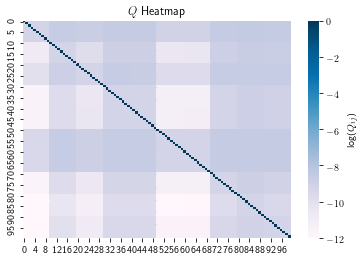

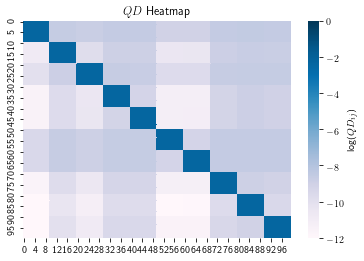

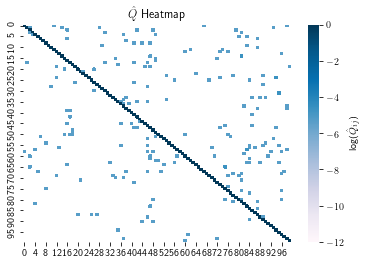

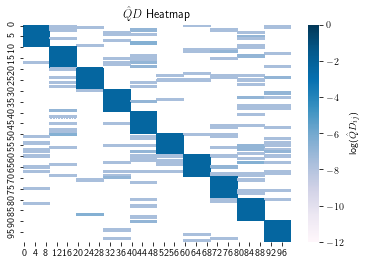

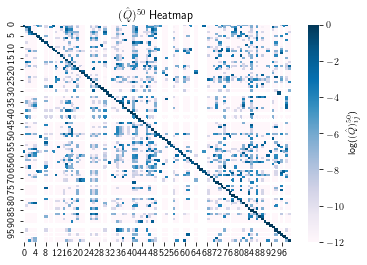

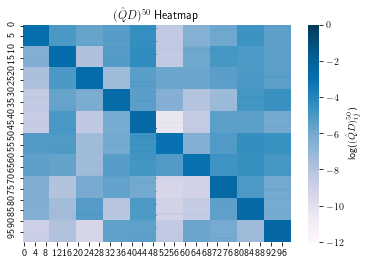

In [13]:
ims = [
    ("Q", Q),
    ("QD", Q @ D),
    ("\hat Q", Qhat),
    ("\hat Q D", Qhat @ D),
    ("(\hat Q)^{50}", np.linalg.matrix_power(Qhat, 50)),
    ("(\hat Q D)^{50}", np.linalg.matrix_power(Qhat @ D, 50)),
]
for matname, mat in ims:
    print(regexp_special_chars.sub("", matname))
    plt.figure()
    heatmap(mat, matname)
    plt.savefig("heatmaps/" + regexp_special_chars.sub("", matname) + ".pdf")